In [7]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from brain_observatory_analysis.behavior.video_qc import annotation_tools
import cv2
from pathlib import Path
from datetime import datetime

In [2]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)
table.project_code.unique()

array(['VisualBehaviorMultiscope', 'LearningmFISHDevelopment', 'U01BFCT',
       'OpenScopeDendriteCoupling', 'VisualBehavior',
       'VisBIntTestDatacube', 'omFISHGad2Meso', 'VisualBehaviorTask1B',
       'MultiscopeSignalNoise', 'omFISHRbp4Meso', 'LearningmFISHTask1A',
       'TaskTrainedNetworksMultiscope',
       'VisualBehaviorMultiscope4areasx2d', 'omFISHSstMeso',
       'VipAxonalV1Phase1', 'MesoscopeDevelopment', 'omFISHCux2Meso',
       'VisualBehaviorIntegrationTest', 'VisualBehaviorDevelopment'],
      dtype=object)

In [10]:
project_codes = ['VisualBehaviorMultiscope', 'VisualBehaviorMultiscope4areasx2d', 'LearningmFISHTask1A', 'omFISHGad2Meso']
table = table[table.project_code.isin(project_codes)]
last_datetime = datetime(2024, 3, 27, 0, 0, 0)
table = table[table.date_of_acquisition < last_datetime]
len(table.ophys_session_id.unique())

962

In [4]:
table.columns

Index(['equipment_name', 'donor_id', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'foraging_id',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type',
       'experience_level', 'passive', 'image_set'],
      dtype='object')

In [66]:
osids = table.ophys_session_id.unique()
osid = osids[0]
session_dir = from_lims.get_session_h5_filepath(osid).parent
ellipse_filepath = from_lims.get_ellipse_filepath(osid)
eye_tracking_movie = from_lims.get_eye_tracking_avi_filepath(osid)

df = annotation_tools.read_DLC_h5file(from_lims.get_deepcut_h5_filepath(osid))
pupil_likelihood_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='likelihood')].reset_index(drop=True)
pupil_x_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='x')].reset_index(drop=True)
pupil_y_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='y')].reset_index(drop=True)

loaded DLC data


Text(0.5, 1.0, 'osid 952430817')

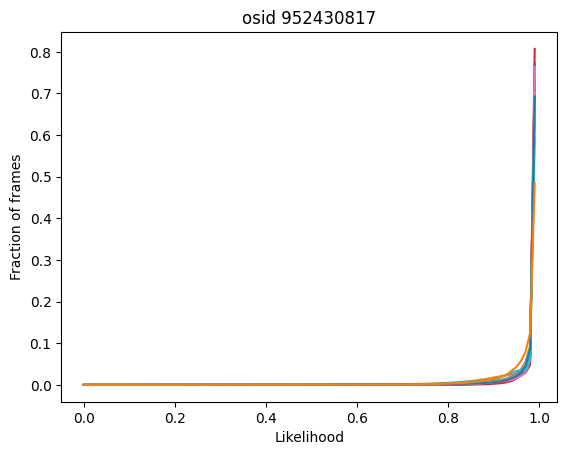

In [67]:
bins = np.linspace(0,1,100)
hist_vals = pupil_likelihood_df.groupby('bodyparts').apply(lambda x: np.histogram(x.value.values, bins=bins)[0]/len(x)).values
fig, ax = plt.subplots()
for i, hist in enumerate(hist_vals):
    ax.plot(bins[:-1], hist, label=pupil_likelihood_df.bodyparts[i])
ax.set_xlabel('Likelihood')
ax.set_ylabel('Fraction of frames')
ax.set_title(f'osid {osid}')

In [109]:
# Takes about 15 minutes

cmap = 'cool'
colors = plt.cm.get_cmap(cmap)(np.linspace(0,1,100))*255
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\qc_pupil'.replace('\\','/'))

cap_eye = cv2.VideoCapture(str(eye_tracking_movie))
width = int(cap_eye.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_eye.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap_eye.get(cv2.CAP_PROP_FPS))
length = int(cap_eye.get(cv2.CAP_PROP_FRAME_COUNT))
assert length == len(pupil_likelihood_df.frame_number.unique())
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
movie_path = save_dir / f'pupil_osid_{osid}.mp4'

out_fps = 5
total_dur = 60 # seconds
out_num_frames = total_dur*out_fps
frame_nums_to_capture = np.linspace(0, length-1, out_num_frames+2).astype(int)[1:-1]
out = cv2.VideoWriter(str(movie_path), fourcc, out_fps, (width, height))

# Define the circle parameters
radius = 1
thickness = 4

for frame_number in frame_nums_to_capture:
    cap_eye.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    ret_eye, frame_eye = cap_eye.read()

    cv2.rectangle(frame_eye, (0,0), (60, 482), (255,255,255), -1)
    for bodyparts in pupil_likelihood_df.bodyparts.unique():
        likelihood = pupil_likelihood_df[(pupil_likelihood_df.bodyparts==bodyparts) &
                                         (pupil_likelihood_df.frame_number==frame_number)].value.values[0]
        color = colors[max(int(np.round(likelihood*100))-1, 0)]
        center_x = int(pupil_x_df[(pupil_x_df.bodyparts==bodyparts) &
                                  (pupil_x_df.frame_number==frame_number)].value.values[0])
        center_y = int(pupil_y_df[(pupil_y_df.bodyparts==bodyparts) &
                                  (pupil_y_df.frame_number==frame_number)].value.values[0])
        cv2.circle(frame_eye, (center_x, center_y), radius, color, thickness)

    out.write(frame_eye)
cap_eye.release()
out.release()



# Look at the distribution of pixel values
- in the center of the image (2/3 in each dimension)
- calculate from 100 frames

In [137]:
cap_eye = cv2.VideoCapture(str(eye_tracking_movie))
width = int(cap_eye.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_eye.get(cv2.CAP_PROP_FRAME_HEIGHT))
xrange = [int(width/6), int(width/6*5)]
yrange = [int(height/6), int(height/6*5)]
length = int(cap_eye.get(cv2.CAP_PROP_FRAME_COUNT))
frame_nums_to_capture = np.linspace(0, length-1, 102).astype(int)[1:-1]
all_pix_vals = []
for frame_number in frame_nums_to_capture:
    cap_eye.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    ret_eye, frame_eye = cap_eye.read()
    pix_vals = frame_eye[yrange[0]:yrange[1], xrange[0]:xrange[1], 1].flatten()
    all_pix_vals.extend(pix_vals)
cap_eye.release()


In [142]:
np.where(bins%7!=0)[0]

array([  1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,  15,
        16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  29,  30,
        31,  32,  33,  34,  36,  37,  38,  39,  40,  41,  43,  44,  45,
        46,  47,  48,  50,  51,  52,  53,  54,  55,  57,  58,  59,  60,
        61,  62,  64,  65,  66,  67,  68,  69,  71,  72,  73,  74,  75,
        76,  78,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  90,
        92,  93,  94,  95,  96,  97,  99, 100, 101, 102, 103, 104, 106,
       107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121,
       122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 134, 135, 136,
       137, 138, 139, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151,
       152, 153, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166,
       167, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181,
       183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 21

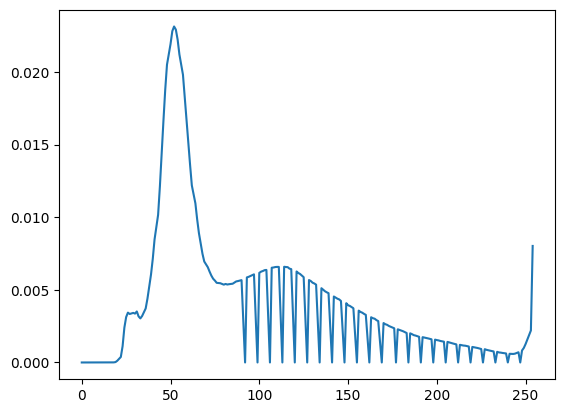

In [144]:
bins = np.arange(0, 256, 1)
hist_vals = np.histogram(all_pix_vals, bins=bins)[0]/len(all_pix_vals)
fig, ax = plt.subplots()
bin_inds = [0, *np.where(bins%7!=0)[0][:-1]]
ax.plot(bins[bin_inds], hist_vals[bin_inds])


In [140]:
np.where(np.histogram(all_pix_vals, bins=bins)[0]==0)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        92,  99, 106, 113, 120, 127, 134, 141, 148, 155, 162, 169, 177,
       184, 191, 198, 205, 212, 219, 226, 233, 240, 247], dtype=int64)

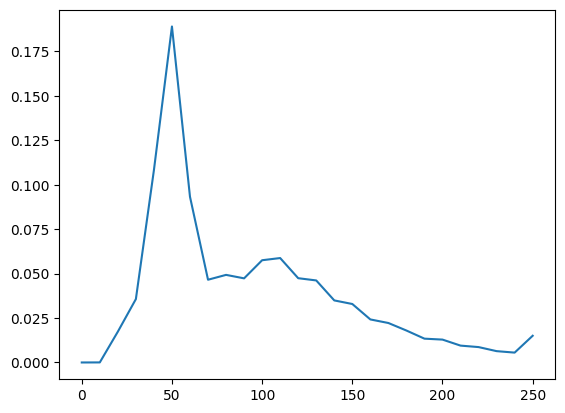

In [146]:
bins = np.arange(0, 256+10, 10)
hist_vals = np.histogram(all_pix_vals, bins=bins)[0]/len(all_pix_vals)
fig, ax = plt.subplots()
ax.plot(bins[:-1], hist_vals)


In [124]:
2**8

256